<a href="https://colab.research.google.com/github/Brymer-Meneses/Plant-Doctor/blob/main/machine_learning/model_training/corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites


In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import os 
import shutil

from zipfile import ZipFile
from os.path import join
from os import listdir
from google.colab import drive

import math 
import random 

In [2]:
drive.mount('drive', force_remount=True)

Mounted at drive


# File Structuring

In [3]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded

--2021-02-20 15:37:22--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066 [following]
--2021-02-20 15:37:22--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/d29ed9b2-8a5d-4663-8a82-c9174f2c7066
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.24.35
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.24.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 868032562 (828M) [application

In [4]:
os.rename('file_downloaded', "plantvillage_ds.zip")
with ZipFile('plantvillage_ds.zip', 'r') as file:
  file.extractall()

os.remove('plantvillage_ds.zip')
os.rename('/content/Plant_leave_diseases_dataset_without_augmentation', "/content/dataset")

In [5]:
# Plants to be deleted 
def delete_plants(dataset_plant):
  dataset_dir = "/content/dataset"
  for plant in os.listdir(dataset_dir):
    if not dataset_plant in plant.lower():
      shutil.rmtree(join(dataset_dir, plant))
  return

In [6]:
def train_val_test_split(source_dir, destination_dir, data_split=[0.6, 0.2, 0.2]):

  """Copies the file structure of a directory and splits it for 
  train, test, validation.

  source_dir/
    ├─ folder1/
    ├─ folder2/
    ├─ .../

  destination_dir/
    |
    ├─ train/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../
    │
    ├─ test/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../
    |
    ├─ val/
    │   ├─ folder1/
    │   ├─ folder2/
    │   ├─ .../

  
  """
  assert float(data_split[0] + data_split[1] + data_split[2]) == 1.0, "Data Split must be equal to 1"
  if not os.path.isdir(destination_dir):
    os.mkdir(destination_dir)
  
  dirs = ["train", "val", "test"]

  for dir in dirs:
    try:
      os.mkdir(os.path.join(destination_dir, dir))
    except Exception as e:
      print(e)

    for plant_type in os.listdir(source_dir):
      try:
        os.mkdir(os.path.join(destination_dir, dir, plant_type))
      except Exception as e:
        print(e)

  
  def split(source, destination, total):
    counter = 0
    while not counter == total:
      random_image = random.choice(os.listdir(source))
      image_source = os.path.join(source, random_image)
     
      image_destination = os.path.join(destination, random_image)

      shutil.move(image_source, image_destination)

      counter += 1
    return

  for folder in os.listdir(source_dir):
    
  
    total_images = len(os.listdir(os.path.join(source_dir, folder)))
    train_total = math.floor(total_images * data_split[0])
    test_total = math.floor(total_images * data_split[1])
    val_total = math.floor(total_images * data_split[2])

    split(join(source_dir, folder), os.path.join(destination_dir, "train", folder), train_total)
    split(join(source_dir, folder), os.path.join(destination_dir, "test", folder), test_total)
    split(join(source_dir, folder), os.path.join(destination_dir, "val", folder), val_total)

    print(f"Successfully splitted data from {os.path.join(source_dir, folder)} {os.path.join(destination_dir, folder)}")
    print(f"\t - Train Images: {train_total}")
    print(f"\t - Val Images: {val_total}")
    print(f"\t - Test Images: {train_total}")
    
  return 






# Model Training

In [7]:
delete_plants("corn")


In [8]:
train_val_test_split("/content/dataset", "/content/split")

Successfully splitted data from /content/dataset/Corn___Cercospora_leaf_spot Gray_leaf_spot /content/split/Corn___Cercospora_leaf_spot Gray_leaf_spot
	 - Train Images: 307
	 - Val Images: 102
	 - Test Images: 307
Successfully splitted data from /content/dataset/Corn___healthy /content/split/Corn___healthy
	 - Train Images: 697
	 - Val Images: 232
	 - Test Images: 697
Successfully splitted data from /content/dataset/Corn___Common_rust /content/split/Corn___Common_rust
	 - Train Images: 715
	 - Val Images: 238
	 - Test Images: 715
Successfully splitted data from /content/dataset/Corn___Northern_Leaf_Blight /content/split/Corn___Northern_Leaf_Blight
	 - Train Images: 591
	 - Val Images: 197
	 - Test Images: 591


In [9]:
from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# We will fine-tune EfficientLite-Lite4
img_size = 380
batch_size = 64

train_dir = "/content/split/train"
val_dir = "/content/split/val"
test_dir = "/content/split/test"

In [11]:
# Data Split
# Training Data - 60%
# Validation Data - 20%
# Test Data - 20%

datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [0.7, 1.3],
    zoom_range = [0.9, 1.1],
    rescale = 1/255,
)

train_gen = datagen.flow_from_directory(
    train_dir, 
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True,
)

test_gen = datagen.flow_from_directory(
    test_dir, 
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = False,
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size = (img_size, img_size),
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True,
)


Found 2310 images belonging to 4 classes.
Found 769 images belonging to 4 classes.
Found 769 images belonging to 4 classes.


In [12]:
URL = 'https://tfhub.dev/tensorflow/efficientnet/lite4/feature-vector/2'
pretrained_model = hub.KerasLayer(URL, input_shape = (img_size, img_size,3))

In [14]:
corn_model = Sequential(name="Corn_Model")
corn_model.add(Flatten())
corn_model.add(Dense(512, activation = 'relu'))
corn_model.add(Dropout(.30))
corn_model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))

training_model = Sequential([
                             pretrained_model, 
                             corn_model,
])

In [15]:
training_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              11837936  
_________________________________________________________________
Corn_Model (Sequential)      (None, 4)                 657924    
Total params: 12,495,860
Trainable params: 657,924
Non-trainable params: 11,837,936
_________________________________________________________________


In [16]:
training_model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])
es = EarlyStopping(monitor = 'val_loss', patience =3)

In [17]:
training_history = training_model.fit(train_gen, validation_data= val_gen, epochs = 5, callbacks = es)

Epoch 1/5
37/37 [==============================] - 119s 3s/step - loss: 0.5883 - accuracy: 0.7783 - val_loss: 0.2215 - val_accuracy: 0.9103
Epoch 2/5
37/37 [==============================] - 108s 3s/step - loss: 0.1617 - accuracy: 0.9366 - val_loss: 0.1570 - val_accuracy: 0.9272
Epoch 3/5
37/37 [==============================] - 107s 3s/step - loss: 0.1486 - accuracy: 0.9368 - val_loss: 0.1776 - val_accuracy: 0.9194
Epoch 4/5
37/37 [==============================] - 109s 3s/step - loss: 0.1314 - accuracy: 0.9441 - val_loss: 0.1693 - val_accuracy: 0.9311
Epoch 5/5
37/37 [==============================] - 107s 3s/step - loss: 0.1267 - accuracy: 0.9496 - val_loss: 0.1632 - val_accuracy: 0.9285


In [18]:
os.chdir("/content/drive/MyDrive/Research/models")
corn_model.save("corn.h5")

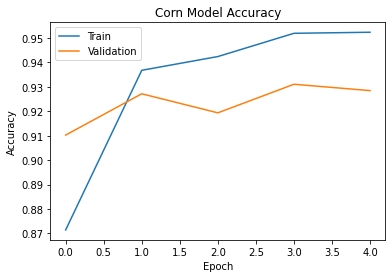

In [19]:
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Corn Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()
